Agent 1 route: [(1, 1), (1, 2), (2, 2), (2, 3), (3, 3), (3, 4), (4, 4), (5, 4), (5, 5), (6, 5), (6, 6), (6, 7), (6, 8), (5, 8)]
Agent 2 route: [(8, 1), (8, 2), (7, 2), (6, 2), (6, 3), (5, 3), (5, 4), (5, 5), (5, 6), (4, 6), (3, 6), (2, 6), (1, 6), (1, 5)]
Agent 3 route: [(8, 8), (8, 7), (7, 7), (7, 6), (6, 6), (6, 5), (6, 4), (6, 3), (6, 2), (6, 1), (5, 1)]
Agent 4 route: [(1, 8), (2, 8), (2, 7), (2, 6), (3, 6), (4, 6), (4, 5), (4, 4), (4, 3), (5, 3), (6, 3), (7, 3), (8, 3), (8, 4)]


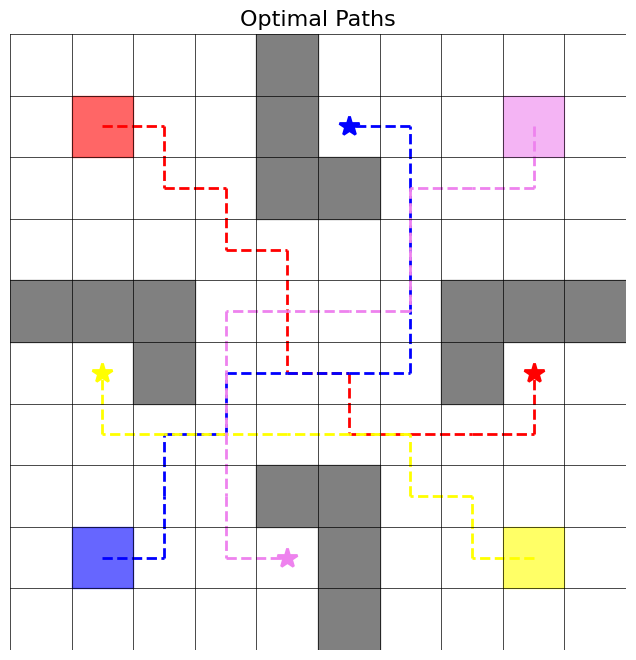

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from collections import defaultdict

# Define constants
MOVES = [(0, 0), (-1, 0), (1, 0), (0, -1), (0, 1)]  # Stay, Up, Down, Left, Right
MOVE_NAMES = ['Stay', 'Up', 'Down', 'Left', 'Right']
NUM_MOVES = len(MOVES)
DISCOUNT = 0.9  # Discount factor
LEARNING_RATE = 0.1  # Learning rate
EXPLORATION = 0.25  # Exploration rate
EPISODE_LIMIT = 500

# Grid world dimensions
WORLD_SIZE = 10
world_map = np.zeros((WORLD_SIZE, WORLD_SIZE), dtype=int)

# Obstacles (walls)
barriers = [
    (0, 4), (1, 4), (2, 4), (2, 5), (4, 0),
    (4, 1), (4, 2), (5, 2), (9, 5), (8, 5),
    (7, 5), (7, 4), (4, 9), (4, 8), (4, 7), (5, 7)
]
for barrier in barriers:
    world_map[barrier] = 1

# Agents' starting points and goal destinations
spawn_points = [(1, 1), (8, 1), (8, 8), (1, 8)]
targets = [(5, 8), (1, 5), (5, 1), (8, 4)]

# Assign colors for visualization
agent_shades = ['red', 'blue', 'yellow', 'violet']

# Environment class for Multi-Agent Pathfinding
class PathfindingEnvironment:
    def __init__(self, world, spawns, destinations):
        self.world = world
        self.spawns = spawns
        self.destinations = destinations
        self.num_agents = len(spawns)
        self.current_state = tuple(spawns)
        self.move_counts = [0] * self.num_agents

    def is_legal_cell(self, position):
        x, y = position
        return 0 <= x < WORLD_SIZE and 0 <= y < WORLD_SIZE and self.world[x, y] != 1

    def reset_environment(self):
        self.current_state = tuple(spawn_points)
        self.move_counts = [0] * self.num_agents
        return self.current_state

    def execute_moves(self, moves):
        intended_positions = []
        rewards = []
        collision_sites = set()

        for idx, move in enumerate(moves):
            current_pos = self.current_state[idx]
            shift = MOVES[move]
            new_pos = (current_pos[0] + shift[0], current_pos[1] + shift[1])

            if not self.is_legal_cell(new_pos) or new_pos in self.current_state:
                new_pos = current_pos
            intended_positions.append(new_pos)

        final_positions = list(self.current_state)
        for idx, new_pos in enumerate(intended_positions):
            if intended_positions.count(new_pos) > 1:
                collision_sites.add(new_pos)
                final_positions[idx] = self.current_state[idx]
            else:
                final_positions[idx] = new_pos

        new_state = tuple(final_positions)
        for idx, new_pos in enumerate(new_state):
            if new_pos == self.destinations[idx]:
                reward = 10
            elif new_pos in collision_sites:
                reward = -10
            else:
                reward = -1
            rewards.append(reward)

        self.current_state = new_state
        finished = all(new_state[idx] == self.destinations[idx] for idx in range(self.num_agents))
        for idx in range(self.num_agents):
            self.move_counts[idx] += 1

        max_moves = max(self.move_counts)
        return self.current_state, rewards, finished, max_moves

# Training function for multi-agent Q-learning
def train_pathfinders(env):
    policies = [defaultdict(lambda: np.zeros(NUM_MOVES)) for _ in range(env.num_agents)]
    shortest_time = float('inf')
    reward_tracker = []

    for ep in range(EPISODE_LIMIT):
        current_state = env.reset_environment()
        completed = False
        total_reward = 0

        while not completed:
            moves = []
            for idx in range(env.num_agents):
                if np.random.rand() < EXPLORATION:
                    move = np.random.choice(NUM_MOVES)
                else:
                    move = np.argmax(policies[idx][current_state[idx]])
                moves.append(move)

            next_state, rewards, completed, longest_path = env.execute_moves(moves)

            for idx in range(env.num_agents):
                curr_q = policies[idx][current_state[idx]][moves[idx]]
                max_next_q = np.max(policies[idx][next_state[idx]])
                policies[idx][current_state[idx]][moves[idx]] = curr_q + LEARNING_RATE * (
                    rewards[idx] + DISCOUNT * max_next_q - curr_q
                )

            total_reward += sum(rewards)
            current_state = next_state

        reward_tracker.append(total_reward)
        shortest_time = min(shortest_time, longest_path)

    return policies, shortest_time, reward_tracker

# Extract optimal paths for visualization
def get_optimal_routes(env, policies):
    routes = []
    for idx in range(env.num_agents):
        current_pos = spawn_points[idx]
        route = [current_pos]

        while current_pos != targets[idx]:
            move = np.argmax(policies[idx][current_pos])
            shift = MOVES[move]
            next_pos = (current_pos[0] + shift[0], current_pos[1] + shift[1])

            if not env.is_legal_cell(next_pos):
                break

            route.append(next_pos)
            current_pos = next_pos

        routes.append(route)
    return routes

# Visualization of the grid and paths
def visualize_routes(world, spawns, destinations, routes):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, WORLD_SIZE)
    ax.set_ylim(0, WORLD_SIZE)

    # Display obstacles
    for x in range(WORLD_SIZE):
        for y in range(WORLD_SIZE):
            if world[x, y] == 1:
                ax.add_patch(patches.Rectangle((y, WORLD_SIZE - x - 1), 1, 1, color='gray'))

    # Display agents' start points and destinations
    for idx, (x, y) in enumerate(spawns):
        ax.add_patch(patches.Rectangle((y, WORLD_SIZE - x - 1), 1, 1, color=agent_shades[idx], alpha=0.6))
    for idx, (x, y) in enumerate(destinations):
        ax.plot(
            y + 0.5, WORLD_SIZE - x - 1 + 0.5,
            marker='*', color=agent_shades[idx], markersize=15, markeredgewidth=2
        )

    # Display paths
    for idx, route in enumerate(routes):
        for j in range(1, len(route)):
            x1, y1 = route[j - 1]
            x2, y2 = route[j]
            ax.plot(
                [y1 + 0.5, y2 + 0.5],
                [WORLD_SIZE - x1 - 1 + 0.5, WORLD_SIZE - x2 - 1 + 0.5],
                color=agent_shades[idx], linewidth=2, linestyle='--'
            )

    # Add grid lines
    for i in range(WORLD_SIZE + 1):
        ax.plot([0, WORLD_SIZE], [i, i], color='black', linewidth=0.5)
        ax.plot([i, i], [0, WORLD_SIZE], color='black', linewidth=0.5)

    ax.set_aspect('equal')
    ax.axis('off')
    plt.title("Optimal Paths", fontsize=16)

# Main function
if __name__ == "__main__":
    sim_env = PathfindingEnvironment(world_map, spawn_points, targets)

    learned_policies, fastest_time, rewards_log = train_pathfinders(sim_env)
    computed_routes = get_optimal_routes(sim_env, learned_policies)
    for idx, route in enumerate(computed_routes):
        print(f"Agent {idx + 1} route: {route}")

    visualize_routes(world_map, spawn_points, targets, computed_routes)
    plt.show()
